## 昨年度のデータが欲しいとき用  
選択の部分と保存先だけ指定すれば順に実行すれば勝手にできるが  
説明が無いので自分の研究の時は使用しないほうがいい

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

C:\Users\shing\Python\research\test\diffae_test\metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 160.69 M


In [ ]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

## 選択

In [ ]:
path_src = 'imgs_evaluate/imgs_source'
for i,file in enumerate(os.listdir(path_src)):
    print(i, file)

**ここで表情を選択(インデントで)**

In [6]:
# 転写元(src)の選択
ind_src = 2

# 転写元画像を並び変えているのでいじらない
# 辞書順になってるのを下の順に並び替える
# all, pose, face, eye, mouth, eye&mouth, mouth&noseの順になってる
ind_parts = [0,1,12,13,6,7,2,5,8,11,3,4,9,10]
path_src_mta = f'{path_src}/{os.listdir(path_src)[ind_src]}'
name_src = os.listdir(path_src)[ind_src]
data_src = ImageDataset(f'{path_src_mta}/parts', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_src = torch.tensor([])
for data in data_src:
    batch_src = torch.cat([batch_src, data['img'][None]])

flag_change = False

In [7]:
path_tgt = 'imgs_evaluate/imgs_target'
for i,file in enumerate(os.listdir(f'{path_tgt}/img')):
    print(i, file)

0 glasses.png
1 takebe_default.png
2 test01_03.png
3 test02_02.png
4 woman_default.png


**ここで変化させる画像を選択(インデントで)**

In [8]:
# 転写先(tgt)の選択
ind_tgt = {0,1,2,3,4}
data_tgt = ImageDataset(f'{path_tgt}/img', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_tgt = torch.tensor([])
name_tgt = []
for i,data in enumerate(data_tgt):
    if i in ind_tgt:
        batch_tgt = torch.cat([batch_tgt, data['img'][None]])
        name_tgt.append(os.path.splitext(str(data_tgt.paths[i]))[0])

flag_change = False

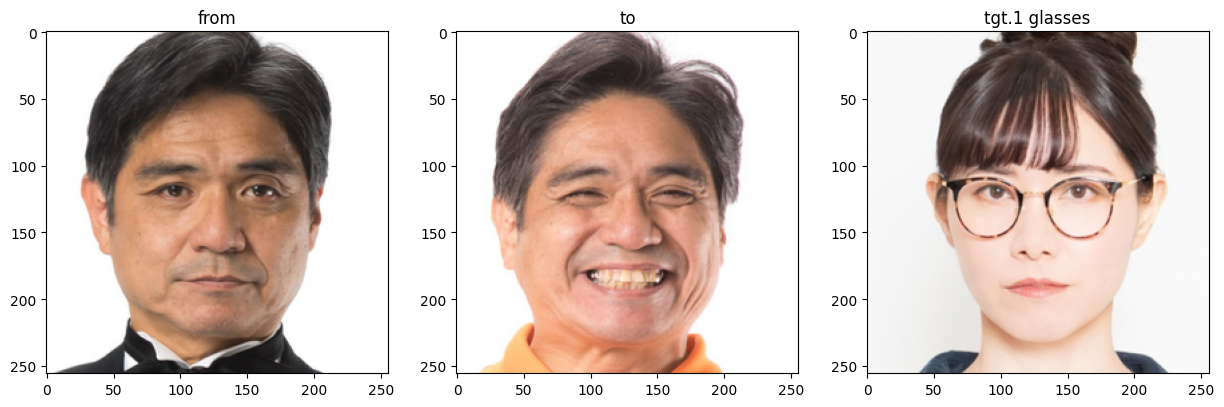

In [9]:
import matplotlib.pyplot as plt

num_tgt = len(batch_tgt)
fig, ax = plt.subplots(1, 2+num_tgt, figsize=(5*(2+num_tgt), 5))
ax[0].imshow(batch_src[0].permute([1, 2, 0]) / 2 + 0.5)
ax[0].set_title(f"from")
ax[1].imshow(batch_src[1].permute([1, 2, 0]) / 2 + 0.5)
ax[1].set_title(f"to")

for i in range(num_tgt):
    ax[i+2].imshow(batch_tgt[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+2].set_title(f"tgt.{i+1} {name_tgt[i]}")

plt.show()

In [10]:
cond_tgt = torch.tensor([], device=device)
xT = torch.tensor([], device=device)
for i in range(num_tgt):
    cond_tgt = torch.cat([cond_tgt, model.encode(batch_tgt[i][None].to(device))], dim=0)
    xT = torch.cat([xT, model.encode_stochastic(batch_tgt[i][None].to(device), cond_tgt[i][None], T=250)], dim=0)

**ここで変化の大きさ及び分割数を選択**  
linspace(始点, 終点, 分割数)

In [11]:
alpha = torch.tensor(np.linspace(0, 1.5, 4, dtype=np.float32)).to(device)

In [12]:
alpha

tensor([0.0000, 0.5000, 1.0000, 1.5000], device='cuda:0')

## all

In [13]:
ind_tmp = [0,1]
batch_src_all = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_all = model.encode(batch_src_all)
cond_change_all = cond_src_all[1] - cond_src_all[0]

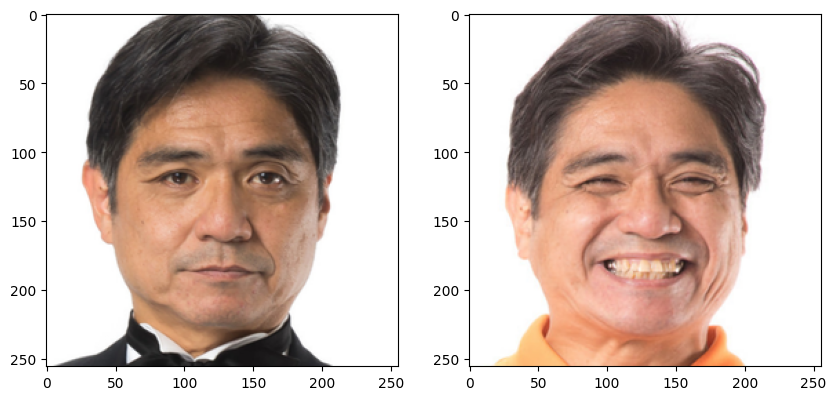

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [15]:
preds_all = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_all
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_all = torch.cat([preds_all, preds_tmp[None]], dim=0)

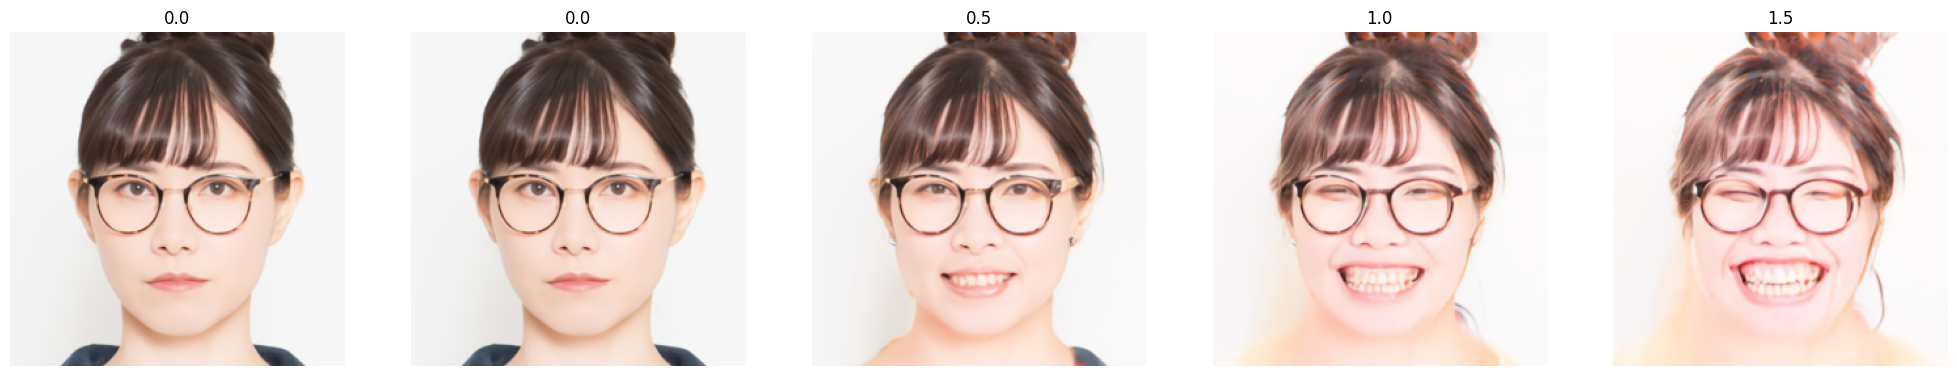

In [17]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_all):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_all) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [18]:
from PIL import Image

preds_all_pil = []
for pred in preds_all:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_all_pil.append(pred_pil)

## pose

In [19]:
ind_tmp = [2,3]
batch_src_pose = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_pose = model.encode(batch_src_pose)
cond_change_pose = cond_src_pose[1] - cond_src_pose[0]

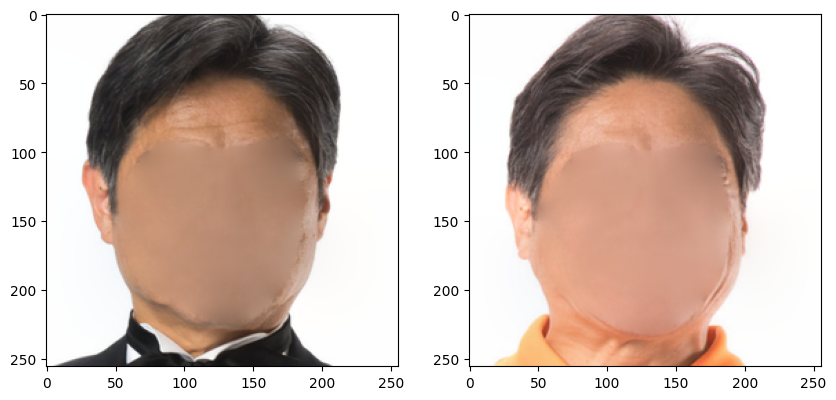

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [21]:
preds_pose = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_pose
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_pose = torch.cat([preds_pose, preds_tmp[None]], dim=0)

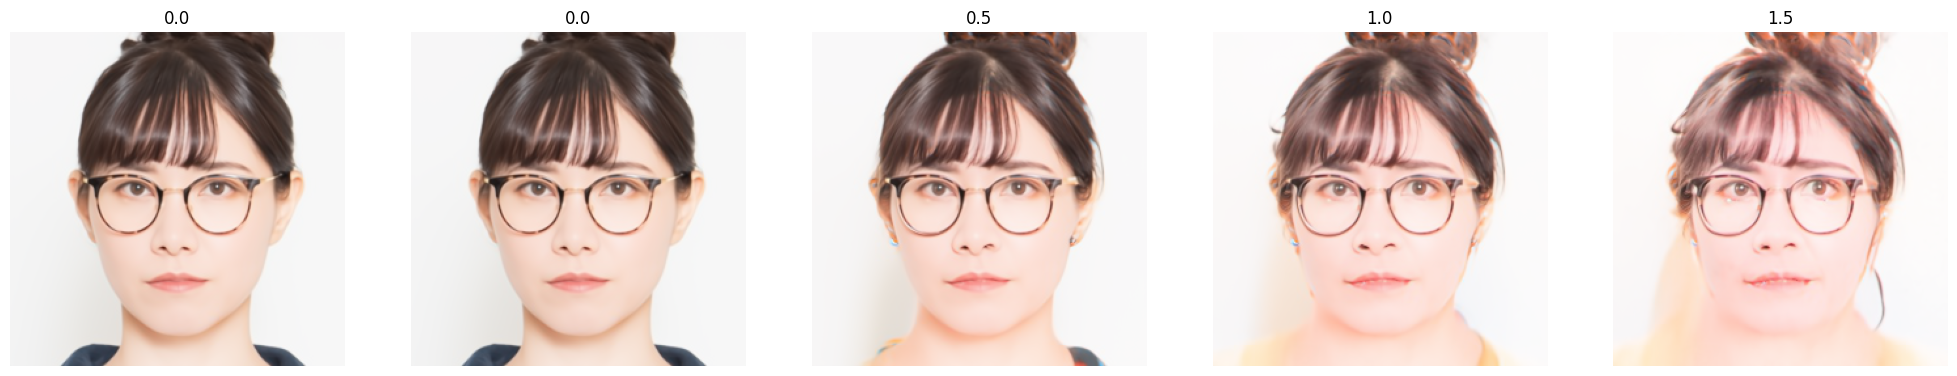

In [22]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_pose):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_pose) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [23]:
from PIL import Image

preds_pose_pil = []
for pred in preds_pose:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pose_pil.append(pred_pil)

## face-all

In [24]:
ind_tmp = [4,5]
batch_src_face = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_face = model.encode(batch_src_face)
cond_change_face = cond_src_face[1] - cond_src_face[0]

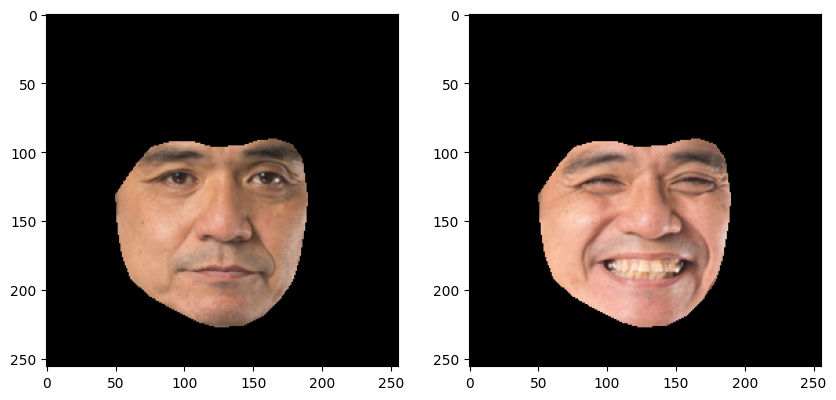

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [26]:
preds_face = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_face
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_face = torch.cat([preds_face, preds_tmp[None]], dim=0)

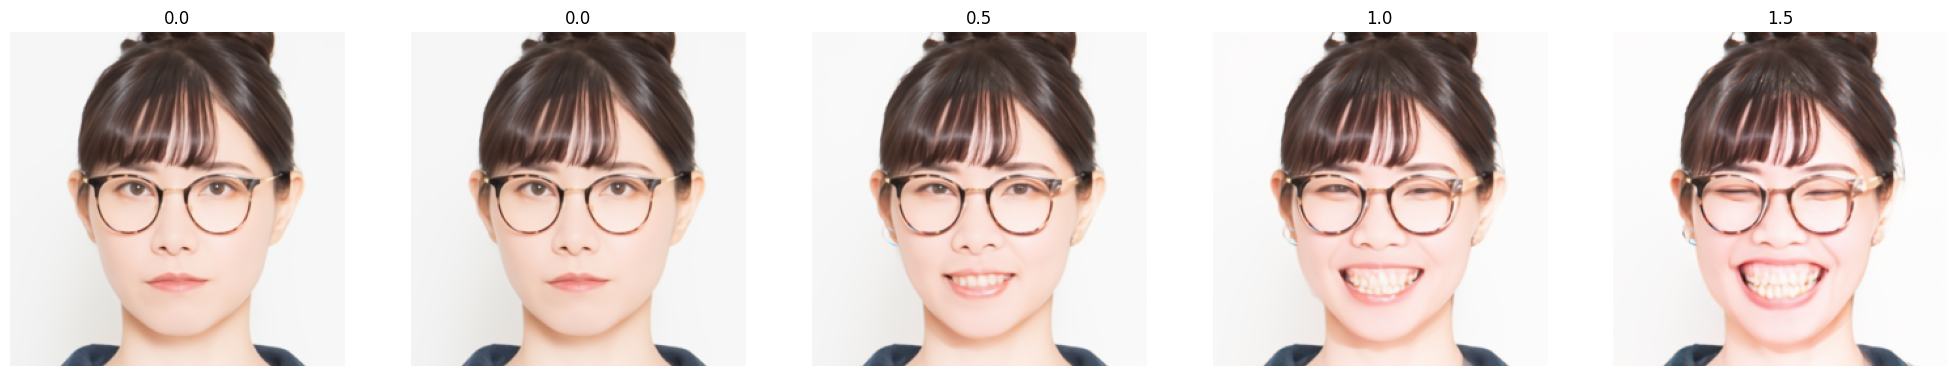

In [27]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_face):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_face) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [28]:
from PIL import Image

preds_face_pil = []
for pred in preds_face:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_face_pil.append(pred_pil)

## eye

In [29]:
ind_tmp = [6,7]
batch_src_eye = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_eye = model.encode(batch_src_eye)
cond_change_eye = cond_src_eye[1] - cond_src_eye[0]

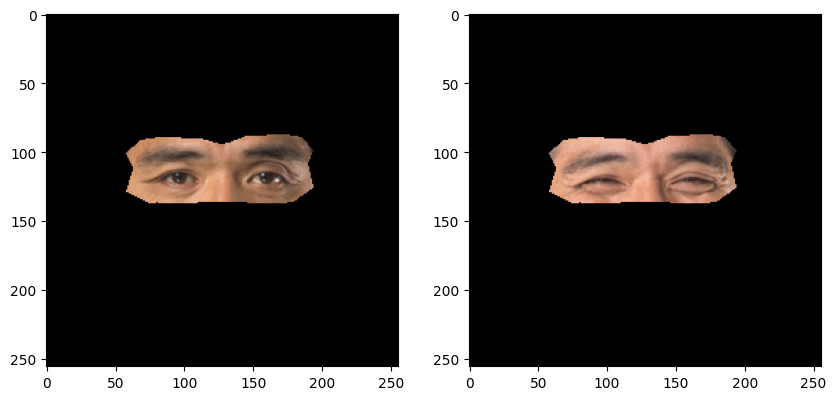

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [31]:
preds_eye = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_eye
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_eye = torch.cat([preds_eye, preds_tmp[None]], dim=0)

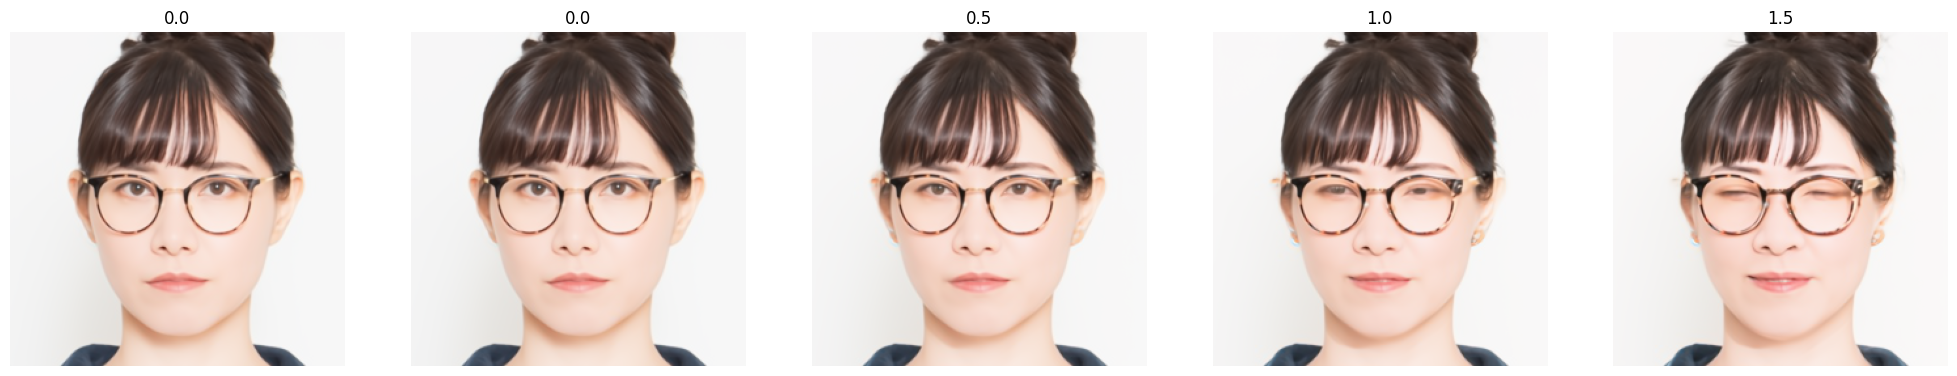

In [32]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_eye):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_eye) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [33]:
from PIL import Image

preds_eye_pil = []
for pred in preds_eye:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_eye_pil.append(pred_pil)

## mouth

In [34]:
ind_tmp = [8,9]
batch_src_mouth = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_mouth = model.encode(batch_src_mouth)
cond_change_mouth = cond_src_mouth[1] - cond_src_mouth[0]

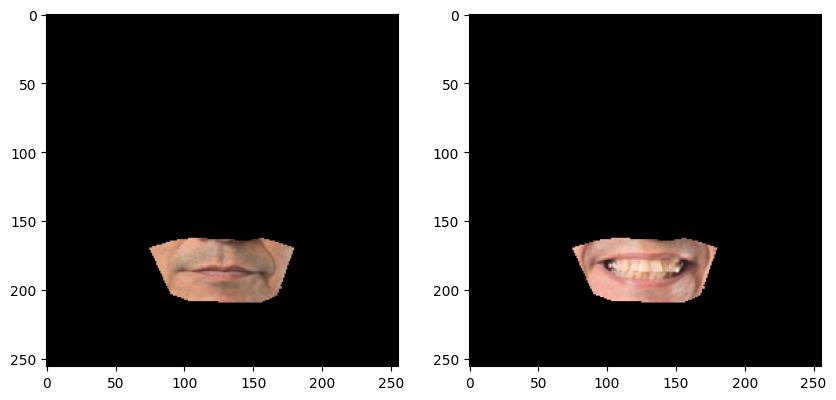

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [36]:
preds_mouth = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_mouth
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_mouth = torch.cat([preds_mouth, preds_tmp[None]], dim=0)

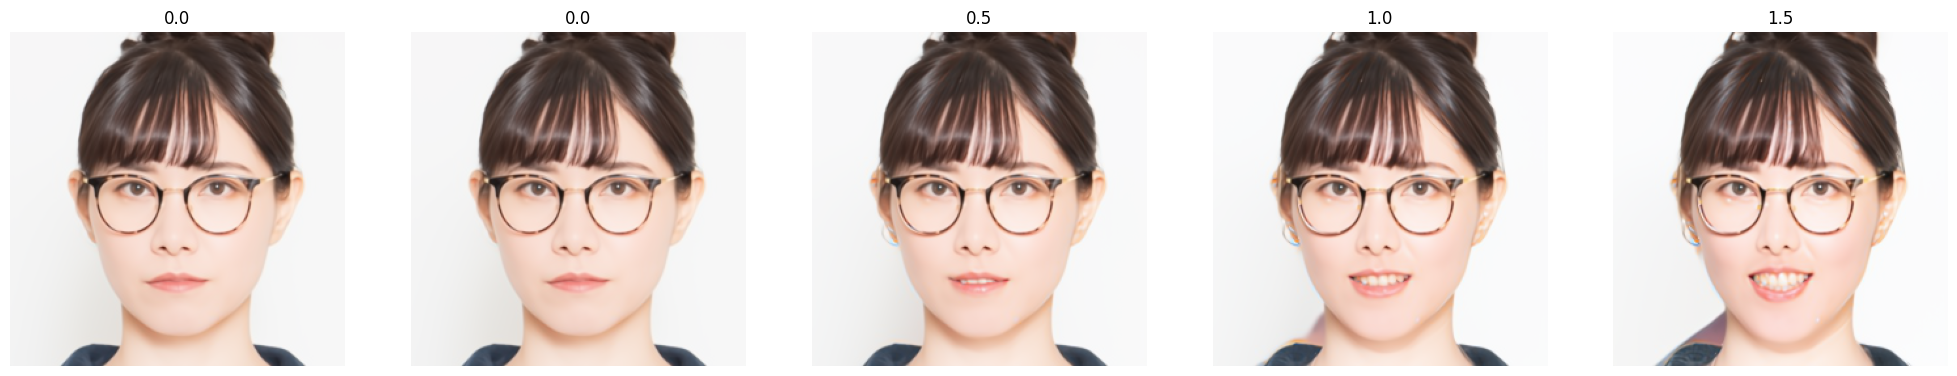

In [37]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_mouth):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_mouth) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [38]:
from PIL import Image

preds_mouth_pil = []
for pred in preds_mouth:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_mouth_pil.append(pred_pil)

## eye&mouth

In [39]:
ind_tmp = [10,11]
batch_src_eyemouth = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_eyemouth = model.encode(batch_src_eyemouth)
cond_change_eyemouth = cond_src_eyemouth[1] - cond_src_eyemouth[0]

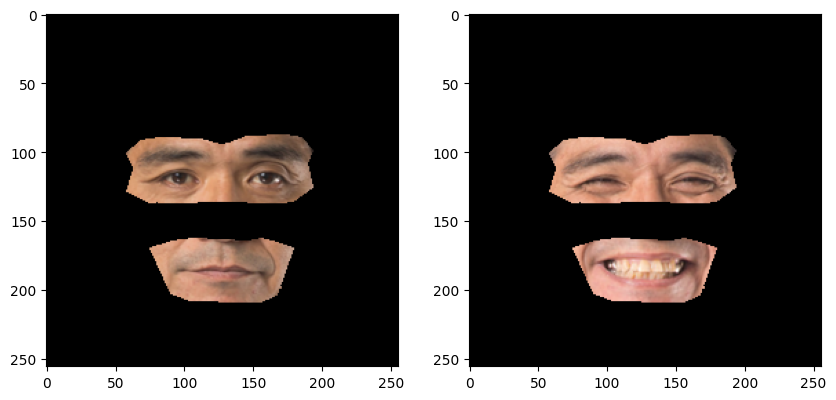

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [41]:
preds_eyemouth = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_eyemouth
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_eyemouth = torch.cat([preds_eyemouth, preds_tmp[None]], dim=0)

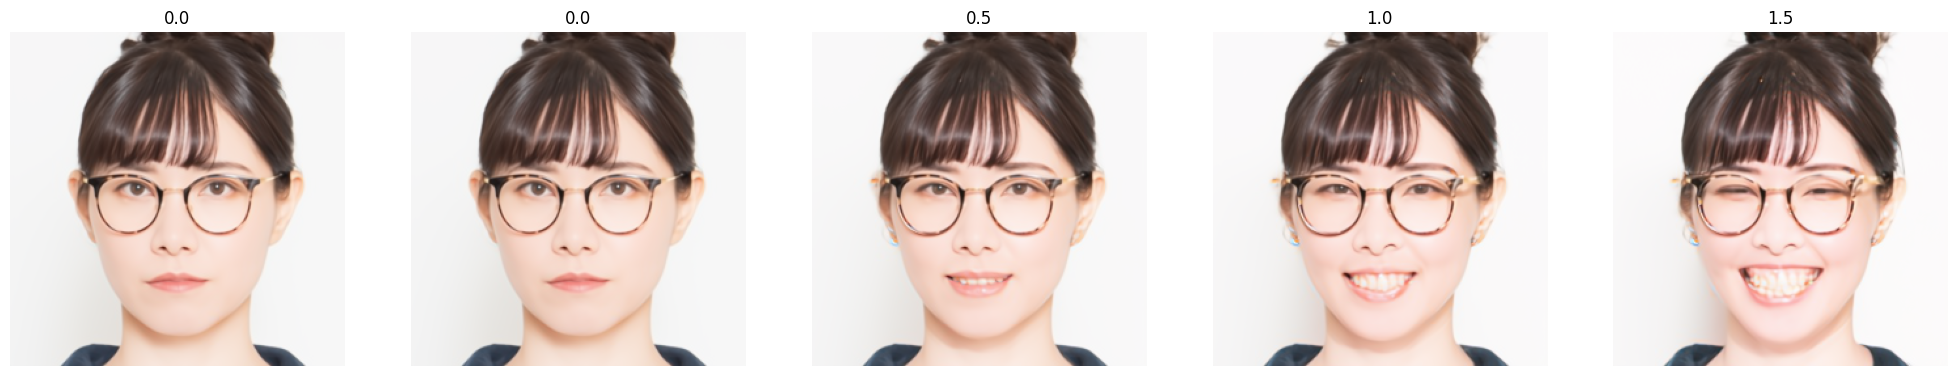

In [42]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_eyemouth):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_eyemouth) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [43]:
from PIL import Image

preds_eyemouth_pil = []
for pred in preds_eyemouth:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_eyemouth_pil.append(pred_pil)

## mouth&nose

In [44]:
ind_tmp = [12,13]
batch_src_mouthnose = torch.stack([batch_src[ind_parts[ind_tmp[0]]], batch_src[ind_parts[ind_tmp[1]]]]).to(device)
cond_src_mouthnose = model.encode(batch_src_mouthnose)
cond_change_mouthnose = cond_src_mouthnose[1] - cond_src_mouthnose[0]

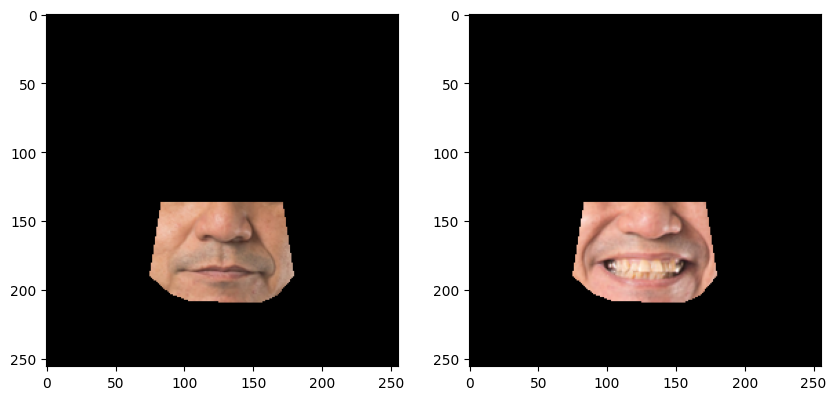

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_parts[ind_tmp[0]]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_parts[ind_tmp[1]]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [46]:
preds_mouthnose = torch.tensor([], device=device)
for i in range(num_tgt):
    preds_tmp = torch.tensor([], device=device)
    for j,alp in enumerate(alpha):
        cond = cond_tgt[i] + alp * cond_change_mouthnose
        pred = model.render(xT[i][None], cond[None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds_mouthnose = torch.cat([preds_mouthnose, preds_tmp[None]], dim=0)

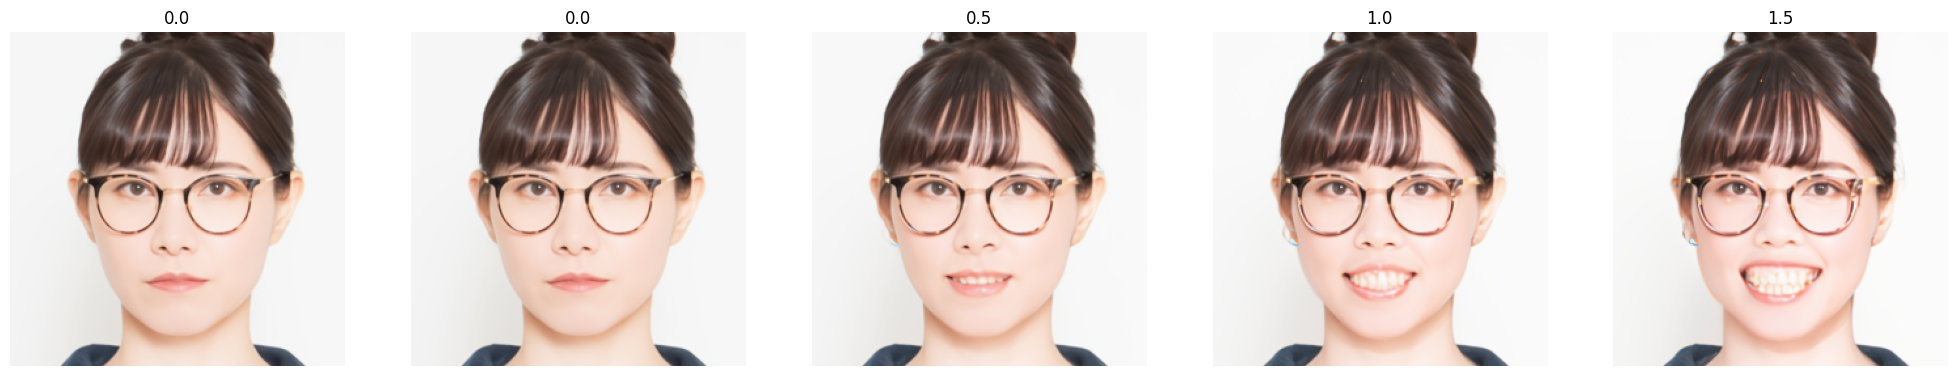

In [47]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds_mouthnose):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds_mouthnose) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [48]:
from PIL import Image

preds_mouthnose_pil = []
for pred in preds_mouthnose:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_mouthnose_pil.append(pred_pil)

## gifの保存

In [49]:
# 保存先ディレクトリ
dst_dir = f"imgs_evaluate/results/{name_src}"

flag_change = True

### all

In [50]:
if flag_change:
    for i,pred_pil in enumerate(preds_all_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/all/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### pose

In [51]:
if flag_change:
    for i,pred_pil in enumerate(preds_pose_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/pose/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### face-all

In [52]:
if flag_change:
    for i,pred_pil in enumerate(preds_face_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/face-all/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### eye

In [53]:
if flag_change:
    for i,pred_pil in enumerate(preds_eye_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/eye/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### mouth

In [54]:
if flag_change:
    for i,pred_pil in enumerate(preds_mouth_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/mouth/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### eye&mouth

In [55]:
if flag_change:
    for i,pred_pil in enumerate(preds_eyemouth_pil):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/eye-mouth/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
        dst_path = dst_dir_parts + file_name
    
        pred_pil[0].save(
            dst_path,
            format="gif",
            save_all=True,
            append_images=pred_pil,
            duration=4000//(len(alpha)),
            loop=0,
        )

### mouth&nose

In [56]:
if flag_change:
    for i,pred_pil in enumerate(preds_mouthnose_pil):
            dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/mouth-nose/"
            if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
            file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
            dst_path = dst_dir_parts + file_name
        
            pred_pil[0].save(
                dst_path,
                format="gif",
                save_all=True,
                append_images=pred_pil,
                duration=4000//(len(alpha)),
                loop=0,
            )

## 静止画像（フレーム）の保存

In [57]:
# select_frame = {0,12,24,36,47,59}
# select_frame = {0,2,4,6,8,10,12,14,15}
# select_frame = {0,6,12,18,24,30}
select_frame = {1,3}

### all

In [58]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_all):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/all/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### pose

In [59]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_pose):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/pose/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### face-all

In [60]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_face):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/face-all/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### eye

In [61]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_eye):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/eye/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### mouth

In [62]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_mouth):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/mouth/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### eye&mouth

In [63]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_eyemouth):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/eye-mouth/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

### mouth&nose

In [64]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_mouthnose):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/mouth-nose/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')

## 評価用画像の生成(おまけ)

In [65]:
eval_imgs_q1 = torch.tensor([])
eval_imgs_pil_q1 = []
eval_imgs_q2 = torch.tensor([])
eval_imgs_pil_q2 = []
a = batch_src[ind_parts[1]].detach().cpu()/2+0.5
br_back = torch.ones(3,256,18)
num_last = 0
for i in range(len(preds_face)):
    b = batch_tgt[i].detach().cpu()/2+0.5
    eval_imgs_q1_tmp = torch.tensor([])
    eval_imgs_pil_q1_tmp = []
    eval_imgs_q2_tmp = torch.tensor([])
    eval_imgs_pil_q2_tmp = []
    for j in range(len(preds_face[0])+num_last):
        if j <= len(preds_face[0])-1:
            c = preds_face[i,j].detach().cpu()
        else:
            c = preds_face[i,-1].detach().cpu()
        img_q1 = torch.cat((b,br_back,c), dim=2)
        eval_imgs_q1_tmp = torch.cat((eval_imgs_q1_tmp, img_q1[None]), dim=0)
        img_q1_np = np.array((img_q1*255).permute(1,2,0).cpu()).astype(np.uint8)
        eval_imgs_pil_q1_tmp.append(Image.fromarray(img_q1_np))
        img_q2 = torch.cat((a,br_back,c), dim=2)
        eval_imgs_q2_tmp = torch.cat((eval_imgs_q2_tmp, img_q2[None]), dim=0)
        img_q2_np = np.array((img_q2*255).permute(1,2,0).cpu()).astype(np.uint8)
        eval_imgs_pil_q2_tmp.append(Image.fromarray(img_q2_np))
    eval_imgs_q1 = torch.cat((eval_imgs_q1, eval_imgs_q1_tmp[None]), dim=0)
    eval_imgs_pil_q1.append(eval_imgs_pil_q1_tmp)
    eval_imgs_q2 = torch.cat((eval_imgs_q2, eval_imgs_q2_tmp[None]), dim=0)
    eval_imgs_pil_q2.append(eval_imgs_pil_q2_tmp)

In [66]:
# 保存先
dst_dir_eval_q1 = f"imgs_evaluate/evaluate/q1"
dst_dir_eval_q2 = f"imgs_evaluate/evaluate/q2"

In [67]:
for i,pred_pil in enumerate(eval_imgs_pil_q1):
    dst_dir_q1 = f"{dst_dir_eval_q1}/"
    if not os.path.exists(dst_dir_q1): os.makedirs(dst_dir_q1)
    file_name = f"{name_src}-trans-{name_tgt[i]}.gif"
    dst_path = dst_dir_q1 + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=4000//(len(alpha)),
        loop=0,
    )

for i,pred_pil in enumerate(eval_imgs_pil_q2):
    dst_dir_q1 = f"{dst_dir_eval_q2}/"
    if not os.path.exists(dst_dir_q1): os.makedirs(dst_dir_q1)
    file_name = f"{name_src}-trans-{name_tgt[i]}.gif"
    dst_path = dst_dir_q1 + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=4000//(len(alpha)),
        loop=0,
    )